# モータモデルのシミュレーション

## 1. ブラシ付き DC モータモデル (外乱あり, フィードフォワード制御)

### 1.1. 導出

DC モータの電気的なモデルを考えます.

参考: [大分大学理工学部松尾研究室資料](https://onsen-mula.org/wp-content/uploads/2017/05/intromech_matsuo.pdf)

![](img/dc_elec.drawio.svg)

誘起電圧 $e$ が角速度 $\omega$ に比例することから回路方程式は以下になります.

$$V = L \dfrac{di}{dt} + Ri + K_E\omega \tag{1}$$

一方機械的なモデルは, 全慣性モーメントを $J$, トルク係数を $K_T$, 粘性抵抗係数を $K_f$, 負荷トルクを $\tau_L$ とすると以下の運動方程式で表されます.

$$J \dfrac{d \omega}{dt} = K_T i - K_f \omega - \tau_L \tag{2}$$

![](img/dc_motion.drawio.svg)

$(1)$ と $(2)$ はそれぞれラプラス変換を行うと

$$V = Lis+ Ri + K_E\omega$$

$$J\omega s = K_Ti - K_f\omega - \tau_L$$

となります. 変形して以下を得ます.

$$i = \dfrac{V - K_E \omega}{Ls + R} \tag{3}$$

$$\omega = \dfrac{K_T i - \tau_L}{Js + K_f} \tag{4}$$

ブロック線図は以下のようになります.

![](img/dc_block.drawio.svg)

Python のシミュレーション用関数を使うためにブロック線図を等価変換します.

参考: [ブロック線図と等価変換](https://denken3web.com/blog/kikai/block-diagram/)

![](img/dc_block_cvt1.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_block_cvt2.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_block_cvt3.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_block_cvt4.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_block_cvt5.drawio.svg)

### 1.2. シミュレーション

In [1]:
!pip install control
!pip install sympy

/usr/local/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=16271) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/home/i9wa4/venv/myenv3.12/lib/python3.12/site-packages/pip/_internal/metadata/importlib/_envs.py:111: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pip._vendor.pkg_resources import find_distributions
/home/i9wa4/venv/myenv3.12/lib/python3.12/site-packages/pip/_internal/metadata/importlib/_envs.py:111: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pip._vendor.pkg_resources import find_distributions


In [2]:
from IPython.display import display, Math
from control.matlab import lsim, tf
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sympy
import warnings

/home/i9wa4/venv/myenv3.12/lib/python3.12/site-packages/japanize_matplotlib/japanize_matplotlib.py:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_support_createFontList = LooseVersion(matplotlib.__version__) < '3.2'
/home/i9wa4/venv/myenv3.12/lib/python3.12/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


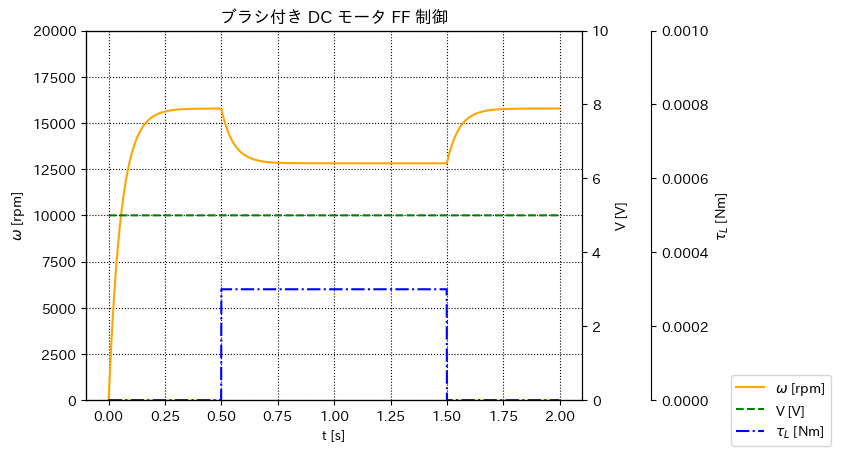

In [3]:
# lsim の警告を無視させます
# 参照: (https://github.com/python-control/python-control/discussions/625)
warnings.simplefilter('ignore')

# DC モータモデルの定数を設定します
# 定数値の参照元:
#   http://www13.plala.or.jp/katsuraan/Old_DCC/Motor1/TOMIX_M4/MotorM4_2.html
#   ※鉄道模型用モータです
V0 = 5              # 電機子電圧 [V]
tauL0 = 3.0e-4      # 負荷トルク [Nm]
R = 9.15            # 電機子抵抗 [Ω]
L = 2.54e-3         # 電機子インダクタンス [H]
Ke = 2.92e-3        # 逆起電力定数 [Vs/rad]
J = 5.31e-8         # 全慣性モーメント [kgm^2]
Kf = 3.36e-8        # 粘性摩擦係数 [Nms/rad]
Kt = 2.92e-3        # トルク定数 [Nm/A] (= Ke)

# 各種伝達関数を定義します
G_H = tf(1, [L, R])
G_I = tf(Kt, 1)
G_J = tf(1, [J, Kf])
G_K = tf(Ke, 1)
G_V2omega = G_H * G_I * G_J / (1 + G_H * G_I * G_J * G_K)
G_tauL2omega = G_J / (1 + G_H * G_I * G_J * G_K)

# 入力を作成します
t = np.arange(0, 2.0, 0.001)
V_in = V0 * (t >= 0)
tauL_in = tauL0 * (t >= 0.5) * (t < 1.5)

# シミュレーションを行います
y_V2omega, _, _ = lsim(G_V2omega, V_in, t, 0)
y_tauL2omega, _, _ = lsim(G_tauL2omega, tauL_in, t, 0)
y_omega = y_V2omega - y_tauL2omega
y_i, _, _ = lsim(G_H, V_in - Ke*y_omega, t, 0)

# rad/s --> rpm の変換を行います
y_rpm = y_omega * 60 / (2 * np.pi)

# ----------------------------
# 以下, グラフの表示設定を行います
# ----------------------------

# ax1-ax4 でX軸を共有します
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# ax4 = ax1.twinx()

# ax1
ax1.set_title('ブラシ付き DC モータ FF 制御')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('$\\omega$ [rpm]')
ax1.set_ylim(0, 20000)
ax1.plot(t, y_rpm, color='orange', linestyle='-', label='$\\omega$ [rpm]')

# ax2
ax2.set_ylabel('V [V]')
ax2.set_ylim(0, 10)
ax2.plot(t, V_in, color='green', linestyle='--', label='V [V]')

# ax3
ax3.set_ylabel('$\\tau_L$ [Nm]')
ax3.set_ylim(0, 1.0e-3)
ax3.plot(t, tauL_in, color='blue', linestyle='-.', label='$\\tau_L$ [Nm]')

# ax4
# ax4.set_ylabel('i [A]')
# ax4.set_ylim(0, 1)
# ax4.plot(t, y_i, color='red', linestyle=':', label='i [A]')

# Y軸の位置を調整します
ax3.spines['right'].set_position(('outward', 50))
# ax4.spines['right'].set_position(('outward', 130))

# 凡例を結合して表示させるために曲線オブジェクトリストとラベルリストを作成します
lines = []
labels = []
for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

# 結合した凡例をグラフ下部領域の左上に置きます
# fig.legend(lines, labels, bbox_to_anchor=(0, 0), loc='upper left')
fig.legend(lines, labels, bbox_to_anchor=(1.3, 0), loc='lower right')

# グリッドを設定します
ax1.grid(which='major', axis='both', linestyle='dotted', color='black')

# グラフを保存します
fig.patch.set_facecolor('xkcd:white')
fig.savefig('img/ff.png', dpi=300, bbox_inches='tight')

### 1.3. 伝達関数

念のため下図の伝達関数を計算します.

![](img/dc_block_cvt5.drawio.svg)

In [4]:
# 記号を定義します
sympy.init_printing()
sympy.var('s R L K_E J K_f K_T')

# 伝達関数を定義します
H = 1 / (L * s + R)
I = K_T
J = 1 / (J * s + K_f)
K = K_E

# V --> omega の伝達関数を求めます
f_V2omega = H * I * J / (1 + H * I * J * K)
f_V2omega = sympy.expand(f_V2omega)
f_V2omega = sympy.simplify(f_V2omega)
f_V2omega = sympy.collect(f_V2omega, s)

# tauL --> omega の伝達関数を求めます
f_tauL2omega = J / (1 + H * I * J * K)
f_tauL2omega = sympy.expand(f_tauL2omega)
f_tauL2omega = sympy.simplify(f_tauL2omega)
f_tauL2omega = sympy.collect(f_tauL2omega, s)

# 計算結果を表示します
display(
    Math(r'G_{V \to \omega} = %s' % (sympy.latex(f_V2omega)))
)
display(
    Math(r'G_{\tau_L \to \omega} = %s' % (sympy.latex(f_tauL2omega)))
)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 2. ブラシ付き DC モータモデル (外乱あり, 速度 PID 制御)

### 2.1. 導出

![](img/dc_pid_block.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt1.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt2.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt3.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt4.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt5.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt6.drawio.svg)

![](img/downarrow.drawio.svg)

![](img/dc_pid_block_cvt7.drawio.svg)

### 2.2. シミュレーション


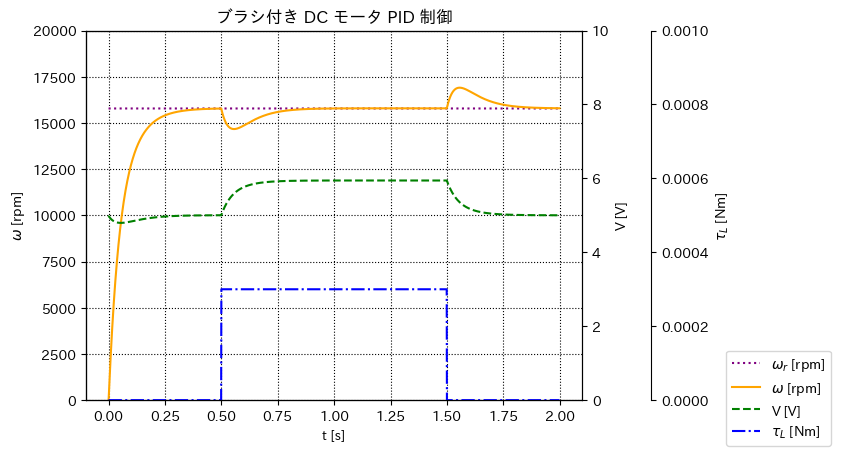

In [5]:
# lsim の警告を無視させます
# 参照: (https://github.com/python-control/python-control/discussions/625)
warnings.simplefilter('ignore')

# DC モータモデルの定数を設定します
# 定数値の参照元:
#   http://www13.plala.or.jp/katsuraan/Old_DCC/Motor1/TOMIX_M4/MotorM4_2.html
#   ※鉄道模型用モータです
tauL0 = 3.0e-4      # 負荷トルク [Nm]
R = 9.15            # 電機子抵抗 [Ω]
L = 2.54e-3         # 電機子インダクタンス [H]
Ke = 2.92e-3        # 逆起電力定数 [Vs/rad]
J = 5.31e-8         # 全慣性モーメント [kgm^2]
Kf = 3.36e-8        # 粘性摩擦係数 [Nms/rad]
Kt = 2.92e-3        # トルク定数 [Nm/A] (= Ke)

# 速度 PID 制御用の定数を設定します
omegar0 = 15783     # 指令速度 [rpm]
Kp = 2.0e-3         # Pゲイン [Vs/rad]
Ki = 5.0e-2         # Iゲイン [Vs/rad]
Kd = 1.0e-3         # Dゲイン [Vs/rad]
Tf = 1.0e-0         # ローパスフィルタ用係数

# 各種伝達関数を定義します
G_H = tf(Kp, 1)
G_I = tf(Ki, [1, 0])
G_J = tf([Kd, 0], [Tf, 1])
G_K = tf(1, [L, R])
G_L = tf(Kt, 1)
G_M = tf(1, [J, Kf])
G_N = tf(Ke, 1)

# omegar --> omega
G_omegar2omega = \
    (
        (G_H + G_I + G_J) * G_K * G_L * G_M / (1 + G_K * G_L * G_M * G_N)
    ) / (
        1 + G_K * G_L * G_M * (G_H + G_I + G_J) / (1 + G_K * G_L * G_M * G_N)
    )

# tauL --> omega
G_tauL2omega = \
    (
        G_M / (1 + G_K * G_L * G_M * G_N)
    ) / (
        1 + G_K * G_L * G_M * (G_H + G_I + G_J)
        / (1 + G_K * G_L * G_M * G_N)
    )

# 入力を作成します
t = np.arange(0, 2.0, 0.001)
omegar_in = omegar0 * (t >= 0) * 2 * np.pi / 60
tauL_in = tauL0 * (t >= 0.5) * (t < 1.5)

# シミュレーションを行います
y_omegar2omega, _, _ = lsim(G_omegar2omega, omegar_in, t, 0)
y_tauL2omega, _, _ = lsim(G_tauL2omega, tauL_in, t, 0)
y_omega = y_omegar2omega - y_tauL2omega
y_V, _, _ = lsim(G_H + G_I + G_J, omegar_in - y_omega, t, 0)
y_i, _, _ = lsim(G_K, y_V - Ke*y_omega, t, 0)

# rad/s --> rpm の変換を行います
y_omega_rpm = y_omega * 60 / (2 * np.pi)
omegar_in_rpm = omegar_in * 60 / (2 * np.pi)

# ----------------------------
# 以下, グラフの表示設定を行います
# ----------------------------

# ax1-ax4 でX軸を共有します
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# ax4 = ax1.twinx()

# ax1
ax1.set_title('ブラシ付き DC モータ PID 制御')
ax1.set_xlabel('t [s]')
ax1.set_ylabel('$\\omega$ [rpm]')
ax1.set_ylim(0, 20000)
# ax1 omegar
ax1.plot(t, omegar_in_rpm, color='purple',
     linestyle=':', label='$\\omega_r$ [rpm]')
# ax1 omega
ax1.plot(t, y_omega_rpm, color='orange', linestyle='-', label='$\\omega$ [rpm]')

# ax2
ax2.set_ylabel('V [V]')
ax2.set_ylim(0, 10)
ax2.plot(t, y_V, color='green', linestyle='--', label='V [V]')

# ax3
ax3.set_ylabel('$\\tau_L$ [Nm]')
ax3.set_ylim(0, 1.0e-3)
ax3.plot(t, tauL_in, color='blue', linestyle='-.', label='$\\tau_L$ [Nm]')

# ax4
# ax4.set_ylabel('i [A]')
# ax4.set_ylim(0, 5)
# ax4.plot(t, y_i, color='red', linestyle=':', label='i [A]')

# Y軸の位置を調整します
ax3.spines['right'].set_position(('outward', 50))
# ax4.spines['right'].set_position(('outward', 130))

# 凡例を結合して表示させるために曲線オブジェクトリストとラベルリストを作成します
lines = []
labels = []
for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

# 結合した凡例をグラフ下部領域の左上に置きます
# fig.legend(lines, labels, bbox_to_anchor=(0, 0), loc='upper left')
fig.legend(lines, labels, bbox_to_anchor=(1.3, 0), loc='lower right')

# グリッドを設定します
ax1.grid(which='major', axis='both', linestyle='dotted', color='black')

# グラフを保存します
fig.patch.set_facecolor('xkcd:white')
fig.savefig('img/pid.png', dpi=300, bbox_inches='tight')

### 2.3. 伝達関数

念のため下図の伝達関数を計算します.

![](img/dc_pid_block_cvt7.drawio.svg)

In [6]:
# 記号を定義します
sympy.init_printing()
sympy.var('s R L K_E J K_f K_T K_P K_I K_D T_f')

# 伝達関数を定義します
H = K_P
I = K_I / s
J = K_D * s / (T_f * s + 1)
K = 1 / (L * s + R)
L = K_T
M = 1 / (J * s + K_f)
N = K_E

# omegar --> omega の伝達関数を求めます
f_omegar2omega_num = (H + I + J)*K*L*M/(1 + K*L*M*N)
f_omegar2omega_num = sympy.expand(f_omegar2omega_num)
f_omegar2omega_num = sympy.simplify(f_omegar2omega_num)
f_omegar2omega = f_omegar2omega_num/(1 + f_omegar2omega_num)
f_omegar2omega = sympy.expand(f_omegar2omega)
f_omegar2omega = sympy.simplify(f_omegar2omega)
f_omegar2omega = sympy.collect(f_omegar2omega, s)

# tauL --> omega の伝達関数を求めます
f_tauL2omega_num = M / (1 + K * L * M * N)
f_tauL2omega_num = sympy.expand(f_tauL2omega_num)
f_tauL2omega_num = sympy.simplify(f_tauL2omega_num)
f_tauL2omega = f_tauL2omega_num / (1 + f_omegar2omega_num)
f_tauL2omega = sympy.expand(f_tauL2omega)
f_tauL2omega = sympy.simplify(f_tauL2omega)
f_tauL2omega = sympy.collect(f_tauL2omega, s)

# 計算結果を表示します
display(Math(r'G_{\omega_r \to \omega} = %s' % (sympy.latex(f_omegar2omega))))
display(Math(r'G_{\tau_L \to \omega} = %s' % (sympy.latex(f_tauL2omega))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 3. まとめ

フィードフォワード制御では負荷がかかると速度を維持できませんが, PID 制御では目標速度に追従できていることが分かります.

![](img/ff.png)

![](img/pid.png)